# Using the samples of the output

13:17 bilby INFO    : Running for label 'linear_regression', output will be saved to 'outdir_Basics_of_parameter_estimation'
Error while loading conda entry point: conda-libmamba-solver (libarchive.so.20: cannot open shared object file: No such file or directory)
13:18 bilby INFO    : Analysis priors:
13:18 bilby INFO    : m=Uniform(minimum=0, maximum=5, name='m', latex_label='m', unit=None, boundary=None)
13:18 bilby INFO    : c=Uniform(minimum=-2, maximum=2, name='c', latex_label='c', unit=None, boundary=None)
13:18 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
13:18 bilby INFO    : Analysis likelihood noise evidence: nan
13:18 bilby INFO    : Single likelihood evaluation took 3.482e-05 s
13:18 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:18 bilby WARNING : Using cached result
13:18 bilby INFO    : Summary of results:
nsamples: 727
ln_noise_evidence:    nan
ln_evidence: -145.167 +/-  0.187
ln_bayes_factor:    nan +/-  

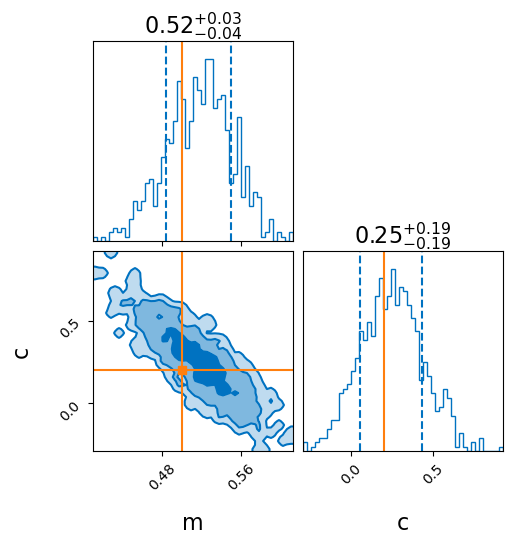

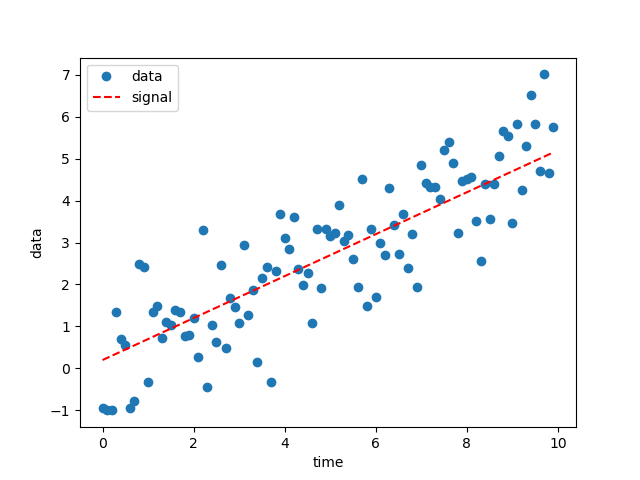

In [ ]:
#!/usr/bin/env python
"""
An example of how to use bilby to perform parameter estimation for
non-gravitational wave data. In this case, fitting a linear function to
data with background Gaussian noise of unknown variance

"""
import bilby
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

# A few simple setup steps
label = "linear_regression"
outdir = "outdir_Basics_of_parameter_estimation"
bilby.utils.check_directory_exists_and_if_not_mkdir(outdir)


# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c


# Now we define the injection parameters which are the "true" values we plug in.
injection_parameters = dict(m=0.5, c=0.2)

# For this example, we'll use standard Gaussian noise

# These lines of code generate the fake data. Note the ** just unpacks the
# contents of the injection_parameters when calling the model function.
sampling_frequency = 10 #in Hz. Number of samples per second 
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency) 
# np.arrange(start, stop, step)
N = len(time) # Total number of samples
sigma = np.random.normal(1, 0.01, N) # Random values drawn from a 
# normal (Gaussian) distribution with mean= 1 and standard deviation= 0.01. 
# This array represents the standard deviation of the noise at each time point.

data = model(time, **injection_parameters) + np.random.normal(0, sigma, N) 
# np.random.normal(loc (i.e the mean or centre of the distribution), 
# scale(SD of the distribution), size (gives output shape)).
# This is the background gaussian noise

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("data")
ax.legend()

fig.savefig("{}/{}_data.png".format(outdir, label))

# Now lets instantiate a version of our GaussianLikelihood, 
# giving it the time, data and signal model
likelihood = bilby.likelihood.GaussianLikelihood(time, data, model, sigma) 
# (x, y, python funtion to fit to the data, sigma) 

# From hereon, the syntax is exactly equivalent to other bilby examples
# The larger the prior range the longer the sampler takes to run
priors = dict() 
priors["m"] = bilby.core.prior.Uniform(0, 5, "m")
priors["c"] = bilby.core.prior.Uniform(-2, 2, "c")

# And run sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors, 
    sampler="dynesty",
    nlive=250, # minimum number of points for a good estimate is 500
               # 1000 is better for gravitational wave problems
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

# Finally plot a corner plot: all outputs are stored in outdir
result.plot_corner()


The samples themselves are stored in the posterior of the result as a panda dataframe. We can print this out if needed.

## The priors used 

A range of uniformly spaced points. 

The height of these points represent the probability density. It is a straight line as a uniform prior has a constant probability density. 

The height of the line is given by $\frac{1}{range}$

$for\ m: \frac{1}{5-0}= 0.2$\
$for\ c: \frac{1}{2-(-2)}= 0.25$

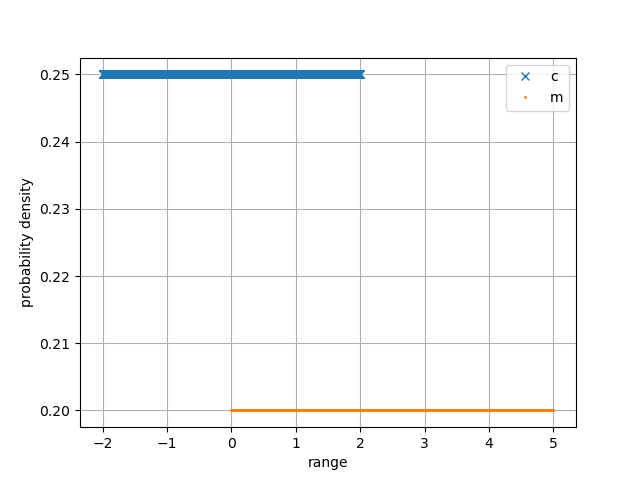

In [2]:
# Computes the probability density of the priors for each value in t
t_m=np.linspace(0,5,1000)
t_c=np.linspace(-2,2,1000)

m= priors['m'].prob(t_m) 
c= priors['c'].prob(t_c)

plt.figure('Priors for m and c')
plt.plot(t_c, c, 'x', label='c')
plt.plot(t_m, m,'o', markersize=1, label='m')
plt.xlabel('range')
plt.ylabel('probability density')
plt.legend()
plt.grid()
plt.show()

Viewing the range of priors on the posterior

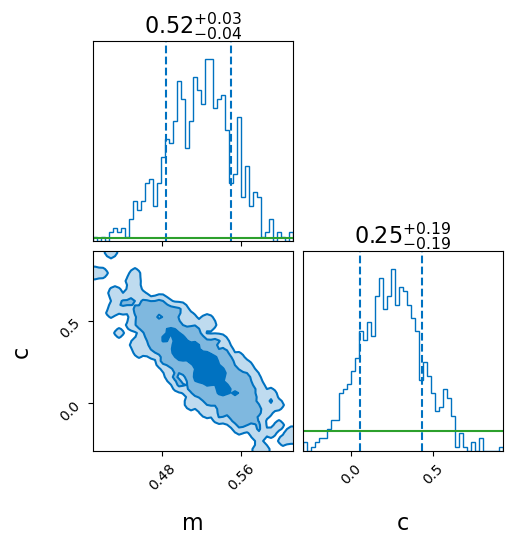

In [3]:
result.plot_corner(parameters=['m','c'], priors=True)

## The likelihood used

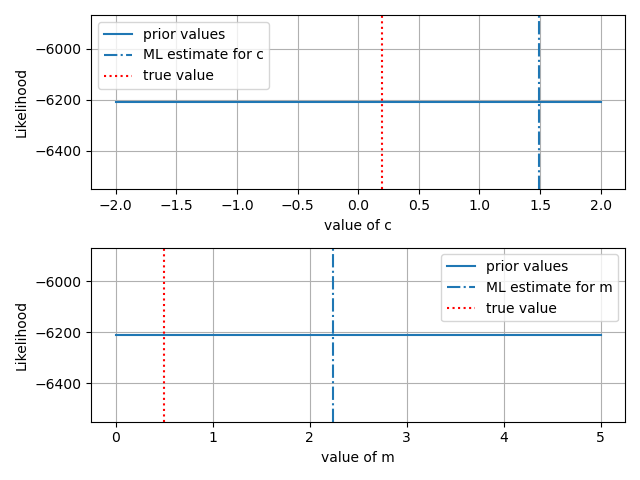

In [4]:
c=0.2
m=0.5

c_grid = np.linspace(-2, +2, 1000)
m_grid = np.linspace(0, 5, 1000)

max_likelihood_c=likelihood.parameters['c']
max_likelihood_m=likelihood.parameters['m']
# Maximum likelihood estimate for m and c coming directly from 
# the bibly likelihood function

ln_likelihood_grid_c=[]
ln_likelihood_grid_m=[]
for _ in c_grid:
    ln_likelihood_grid_c.append(likelihood.log_likelihood())
for _ in m_grid:
    ln_likelihood_grid_m.append(likelihood.log_likelihood())


plt.figure('Maximum Likelihood estimates for m and c')

plt.subplot(2,1,1)
plt.plot(c_grid, ln_likelihood_grid_c, label='prior values')
plt.axvline(max_likelihood_c, ls='-.', label="ML estimate for c")
plt.axvline(c, ls=':', label="true value", color='red')

plt.xlabel('value of c')
plt.ylabel('Likelihood')
plt.legend()
plt.grid()


plt.subplot(2,1,2)
plt.plot(m_grid, ln_likelihood_grid_m, label='prior values')
plt.axvline(max_likelihood_m, ls='-.', label="ML estimate for m")
plt.axvline(m, ls=':', label="true value", color='red')

plt.xlabel('value of m')
plt.ylabel('Likelihood')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Plotting a 1D marginalized distribution for m

Same as what we did before with the CDF using the grid method.

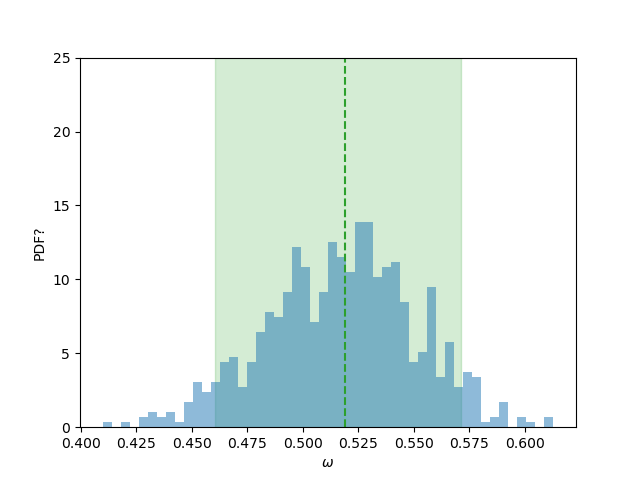

In [5]:
m_samples=result.posterior["m"]
median=np.quantile(m_samples, 0.5)
lower_bound=np.quantile(m_samples, 0.05)
upper_bound=np.quantile(m_samples, 0.95)

plt.figure()
plt.fill_between([lower_bound,upper_bound], 0, 200, color='C2', alpha=0.2)
plt.axvline(median, ls='--', label='median value of m', color='C2')
_=plt.hist(m_samples, bins=50, density=True, alpha=0.5)
plt.ylim(0, 25)
plt.xlabel('$\omega$')
plt.ylabel('PDF?')
plt.show()


You can also look at the posterior uncertainty. Code in the video

# Using the result object

In [6]:
result.posterior.head()

,m,c,log_likelihood,log_prior
0,0.428865,0.924687,-144.610825,-2.995732
1,0.434673,0.429496,-143.732644,-2.995732
2,0.454462,0.300125,-143.255720,-2.995732
3,0.409772,0.794778,-143.255010,-2.995732
4,0.527084,0.496756,-142.860343,-2.995732


In [7]:
result.outdir # to check the location of the output directory

'/home/kay/anaconda3/envs/thesis/Thesis Codes/bilby workshop/outdir_Basics_of_parameter_estimation'

In [8]:
result_loaded=bilby.result.read_in_result("outdir_Basics_of_parameter_estimation/linear_regression_result.json")
print(result_loaded)

nsamples: 727
ln_noise_evidence:    nan
ln_evidence: -145.167 +/-  0.187
ln_bayes_factor:    nan +/-  0.187



In [9]:
print(result_loaded.log_evidence)
print(result_loaded.injection_parameters)
print(result_loaded.sampling_time)
print(result.version)

-145.16683917055693
{'m': 0.5, 'c': 0.2}
0:00:06.067662
bilby=2.3.0


You can plot the true values manually if you didn't store them before

You can even make corner plots without the true values

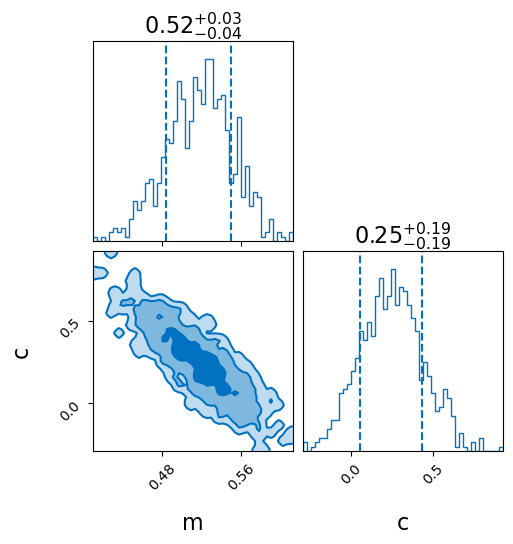

In [10]:
result.plot_corner (['m', 'c'])

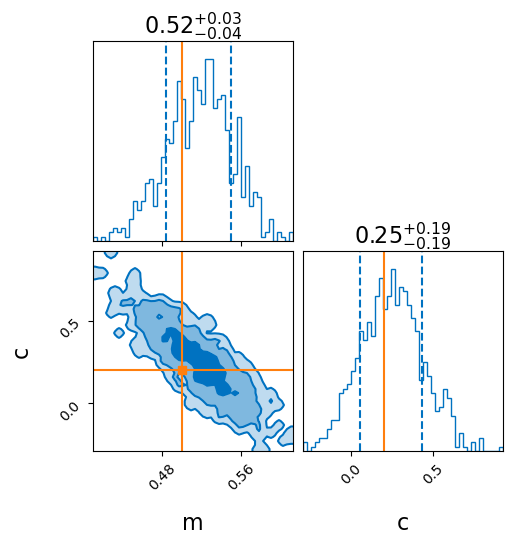

In [11]:
result.plot_corner(dict(m=0.5, c=0.2)) 
# same plot that is automatically created and saved in the outdir folder